In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
from scipy.fftpack import fftn, fftshift
from scipy.ndimage import gaussian_filter,gaussian_laplace
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Load data

In [3]:
# loading data
store_img = np.load('data/321_sim_var.npy')
store_img_noiseless = np.load('data/321_sim_var_noiseless.npy')


# Apply Gaussian filter to sim. image with noise
store_img_gaussian = np.zeros(shape = store_img.shape)
for i in range(store_img.shape[2]):
    store_img_gaussian[:,:,i] = gaussian_filter(store_img[:,:,i], sigma=8)

In [4]:
'''
Plotting function
'''
def view_sims (store_img):
    def get_lh (data,clip_percent = 1):
        lo, hi = np.percentile(
            data.ravel(), (0.5 * clip_percent, 100 - 0.5 * clip_percent))
        return(lo,hi)

    ac_time = ['7:00 pm','8:00 pm','9:00 pm','10:00 pm','11:00 pm','12:00 am','1:00 am','2:00 am','3:00 am','4:00 am','5:00 am']
    fig,axes = plt.subplots(3,4,figsize = (15,13),sharex='all', sharey='all')
    fig.subplots_adjust(wspace=0.04, hspace=0.05)
    k = 0
    j = 0
    for i in range(len(store_img[0,0,:])):
        lo,hi = get_lh(store_img[:,:,i])
        axes[j,k].set_title(ac_time[i],fontsize=20)
        axes[j,k].imshow(store_img[:,:,i],cmap='gray', vmin=lo, vmax=hi,interpolation='nearest')
        axes[j,k].axis('off')
        if k!= 0 and k%3 == 0:
            k = 0
            j += 1
        else:
            k += 1
    # remove unused plot
    fig.delaxes(axes[-1][-1])
    
'''
Functions that normalize simulated image to RMS and flatten the image array for PCA analysis
'''   
# Standardize and flatten sim data
def flatten_and_std (store_img):
    sim_matrix = np.zeros((store_img[:,:,0].size,store_img.shape[2]))
    for i in range(store_img.shape[2]): 
        sim_array = store_img[:,:,i].flatten()
        # Normalized data to RMS
        sim_standard = sim_array/np.sqrt(np.mean(sim_array**2))
        sim_matrix[:,i] = sim_standard
    return(sim_matrix)

# Simualted image with Poisson and readout noise
sim_matrix = flatten_and_std(store_img)

# Simualted noiseless image
sim_noiseless_matrix = flatten_and_std(store_img_noiseless)

# Simualted image with Poisson and readout noise. But a guassian filter is applied to it
sim_gaussian_matrix = flatten_and_std(store_img_gaussian)

In [5]:
'''
Function that perform PCA analysis
'''

def eigen (sim_matrix): 
    # Covariance
    np.set_printoptions(precision=8)
    cov = np.cov(sim_matrix.transpose())

    # Eigen Values
    EigVal,EigVec = np.linalg.eig(cov)

    print("Eigenvalues:\n\n", EigVal,"\n")


    # Ordering Eigen values and vectors
    order = EigVal.argsort()[::-1]
    EigVal = EigVal[order]
    EigVec = EigVec[:,order]

    #Projecting data on Eigen vector directions resulting to Principal Components 
    PC = np.matmul(sim_matrix,EigVec)   #cross product
    
    #Information Retained by Principal Components
    plt.figure(figsize=(8,6))
    plt.bar([1,2,3,4,5,6,7,8,9,10,11],EigVal/sum(EigVal)*100,align='center',width=0.4,
            tick_label = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11'])
    plt.ylabel('Variance (%)', fontsize = 20)
    plt.title('Information retention',fontsize = 20)
    
    return(PC)

'''
Reshape Principle Components into 2d images
'''
def plot_PC (PC):
    PC_2d = np.zeros((store_img.shape[0], store_img.shape[1], store_img.shape[2]))
    
    for i in range(store_img.shape[2]):
        PC_2d[:,:,i] = PC[:,i].reshape(-1,4000)
        
    fig,axes = plt.subplots(3,4,figsize=(15,13),sharex='all',
                            sharey='all')
    fig.subplots_adjust(wspace=0.1, hspace=0.15)
    fig.suptitle('Principal Components ', fontsize=30)

    axes = axes.ravel()
    for i in range(store_img.shape[2]):
        axes[i].imshow(PC_2d[:,:,i],cmap='gray',interpolation = 'nearest')
        axes[i].set_title('PC '+str(i+1),fontsize=25)
        axes[i].axis('off')
    fig.delaxes(axes[-1])

## Case 1: Pure simulation without readout noise and poisson noise

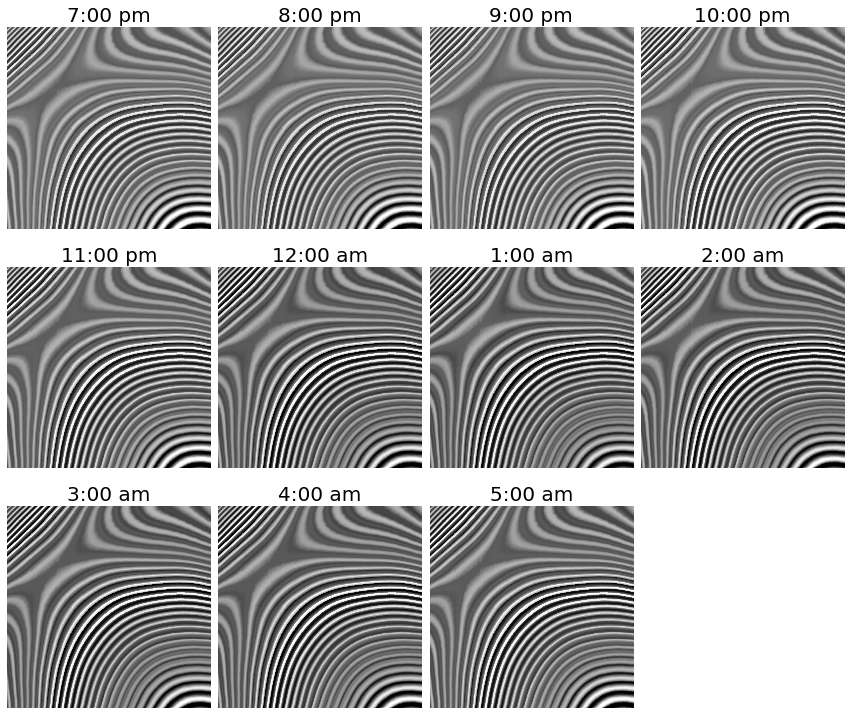

In [6]:
# view hourly simulation
view_sims(store_img_noiseless)

Eigenvalues:

 [ 8.44112323e-06  1.22903538e-07  1.64199911e-09  1.61211828e-10
  1.35044202e-11  1.74461019e-13  1.70393848e-20 -1.82595499e-20
  8.51525635e-21 -2.04404025e-21 -4.56800802e-21] 



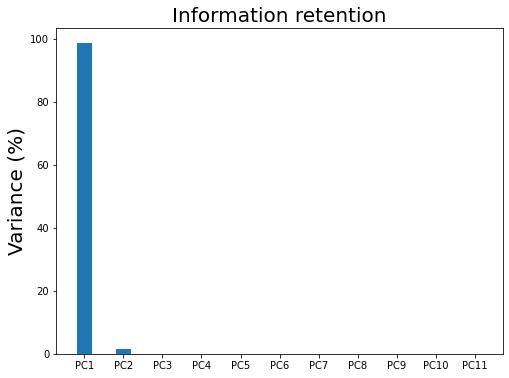

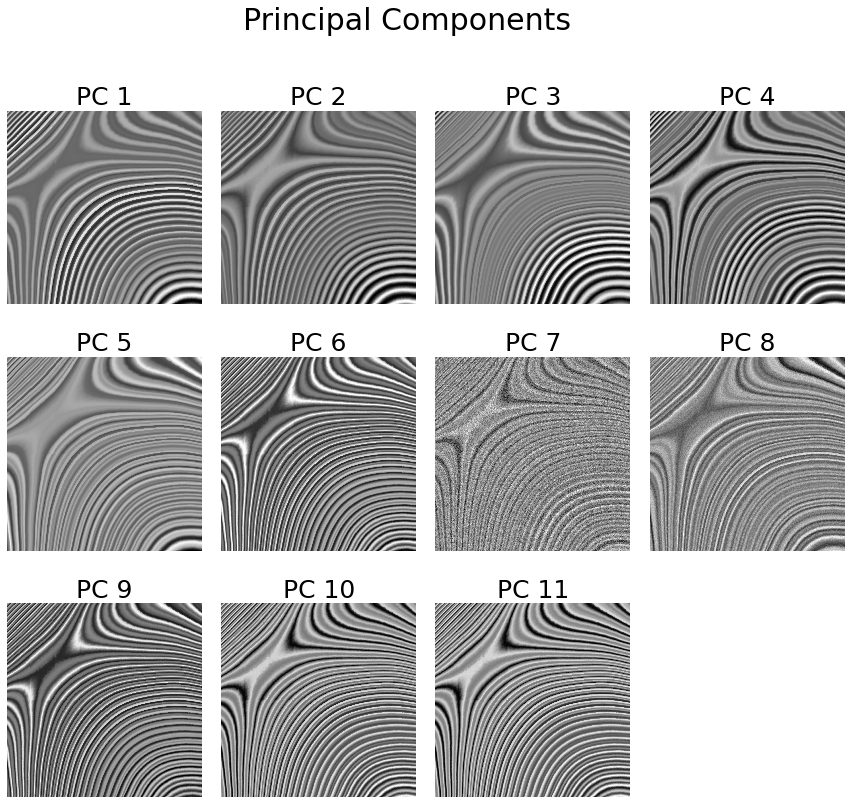

In [7]:
PC = eigen(sim_noiseless_matrix)
plot_PC(PC)

## Case 2: Poisson and readout noise inlcuded Simulation. But with a guassian filter applied to it

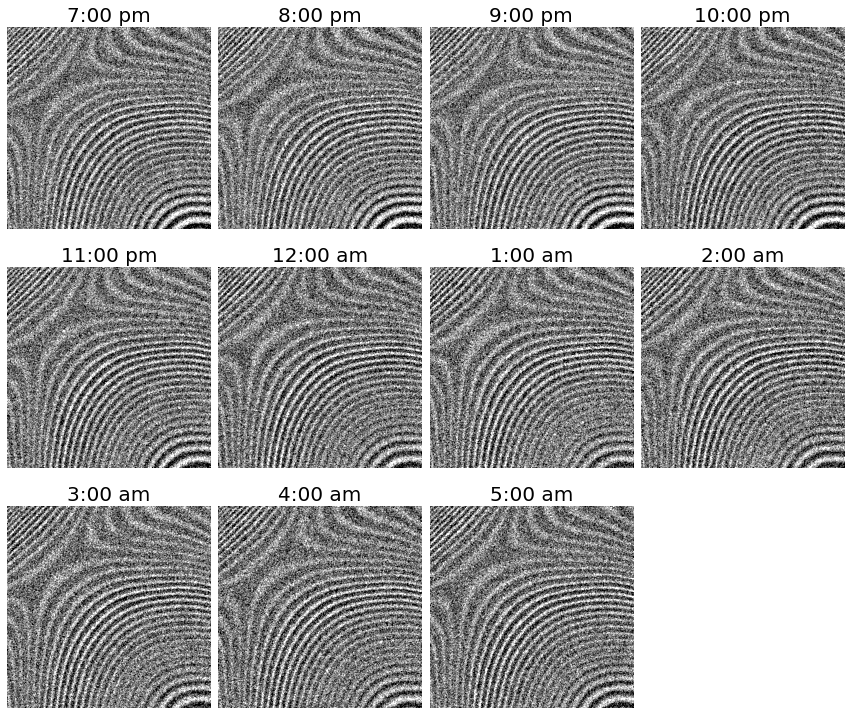

In [8]:
# view hourly simulation
view_sims(store_img_gaussian)

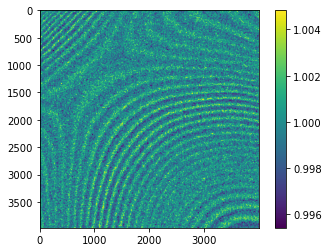

In [9]:
# Plot an example of the standardized sim data
plt.imshow(sim_gaussian_matrix.reshape(store_img.shape[0], store_img.shape[1], 
                                       store_img.shape[2])[:,:,-5],interpolation='nearest')
plt.colorbar()

Eigenvalues:

 [7.85274682e-06 7.30736071e-07 6.43421185e-07 6.31583620e-07
 6.24491883e-07 5.86424268e-07 6.11710121e-07 6.07455549e-07
 5.99787242e-07 5.95944756e-07 5.94723684e-07] 



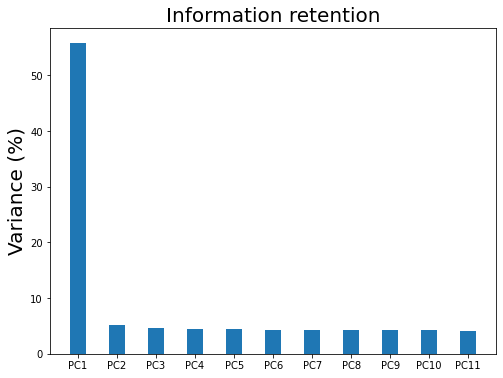

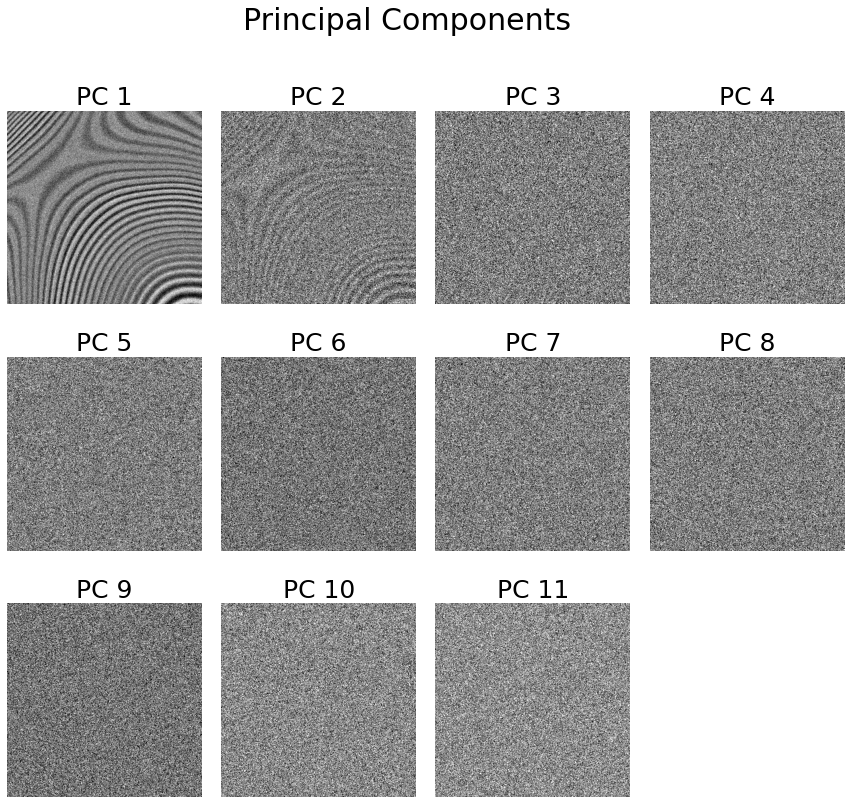

In [10]:
PC = eigen(sim_gaussian_matrix)
plot_PC(PC)